In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np

### User Defined Function

In [2]:
def measure_momentum(time_series, price_series, start_idx, max_ms=50):
    start_time = time_series.iloc[start_idx]
    start_price = price_series.iloc[start_idx]

    # Direction of change (sign of future - current)
    if start_idx + 1 >= len(price_series):
        return 0, 0
    direction = np.sign(price_series.iloc[start_idx + 1] - start_price)
    if direction == 0:
        return 0, 0  # no movement

    for i in range(start_idx + 1, len(price_series)):
        time_diff_ms = (time_series.iloc[i] - start_time).total_seconds() * 1000
        if time_diff_ms > max_ms:
            break
        delta = price_series.iloc[i] - start_price
        if np.sign(delta) != direction:
            break
    else:
        i = start_idx  # if no forward progress

    return time_diff_ms, delta

In [3]:
df = pd.read_csv('./data/df_final_merged.csv')

In [4]:
df['time'] = pd.to_datetime(df['time'], format='mixed', errors='coerce')
df = df.sort_values("time")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291966 entries, 0 to 291965
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   time                       291966 non-null  datetime64[ns, UTC]
 1   index                      291966 non-null  int64              
 2   symbol                     291966 non-null  object             
 3   price                      291966 non-null  float64            
 4   quantity                   291966 non-null  float64            
 5   is_market_maker            291966 non-null  object             
 6   bid_price_spot             291966 non-null  float64            
 7   ask_price_spot             291966 non-null  float64            
 8   mid_price_spot             291966 non-null  float64            
 9   price_dev                  291966 non-null  float64            
 10  trade_direction            291966 non-null  int64            

In [6]:
df.timedelta_ms

0            NaN
1          141.0
2         1301.0
3          666.0
4         1735.0
           ...  
291961    1308.0
291962       0.0
291964       0.0
291963     797.0
291965    3282.0
Name: timedelta_ms, Length: 291966, dtype: float64

### Sudden Price Flag

In [7]:
df['spot_sudden_flag'] = (
    (df['window_3_pct_change'] < -0.00587) |
    (df['window_3_pct_change'] > -0.00308)
).astype(int)

df['perp_sudden_flag'] = (
    (df['window_3_pct_change_perp'] < -0.001) |
    (df['window_3_pct_change_perp'] > 0.247)
).astype(int)

### Predicting Perpetual Based on Spot Market

In [8]:
features = [
    'spot_sudden_flag',
    'timedelta_ms',
    'mid_price_spot',
    'price_dev',
    'rolling_signed_volume_3ms',
    'rolling_signed_volume_5ms',
    'trade_direction'
]
target = 'window_5_pct_change_perp'

# Drop rows with missing values
df_model = df[features + [target]].dropna().reset_index(drop=True)

# Scale features
scaler = StandardScaler()
X_data = scaler.fit_transform(df_model[features].values)
y_data = df_model[target].values

In [9]:
with pm.Model() as model_5ms_t:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # v_ = pm.Exponential("v_", 1/29) 
    # v = pm.Deterministic("v", v_+1) # weakly informative prior

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    # y_pred = pm.StudentT('y', mu=u, sigma=sigma, nu=v, observed=y_data)
    y_pred = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_5ms_t = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_5ms_t.extend(pm.sample_posterior_predictive(idata_5ms_t))

Initializing NUTS using jitter+adapt_diag...
/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [y]


Output()

In [10]:
az.summary(idata_5ms_t, var_names=["a", "beta", "sigma"], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.023,0.002,-0.026,-0.020,0.0,0.0,4678.0,2923.0,1.0
beta[0],0.019,0.002,0.016,0.022,0.0,0.0,5443.0,2865.0,1.0
beta[1],0.005,0.002,0.002,0.008,0.0,0.0,5483.0,2755.0,1.0
beta[2],0.003,0.002,-0.000,0.006,0.0,0.0,5897.0,3304.0,1.0
beta[3],0.114,0.002,0.110,0.118,0.0,0.0,3937.0,2491.0,1.0
beta[4],0.063,0.003,0.057,0.070,0.0,0.0,2770.0,3014.0,1.0
beta[5],-0.023,0.003,-0.028,-0.017,0.0,0.0,2913.0,2868.0,1.0
beta[6],-0.020,0.002,-0.024,-0.017,0.0,0.0,4250.0,2994.0,1.0
sigma,0.289,0.001,0.287,0.291,0.0,0.0,5770.0,3238.0,1.0


In [11]:
y_pred_samples = idata_5ms_t.posterior_predictive["y"].stack(sample=("chain", "draw")).values
y_pred_mean = y_pred_samples.mean(axis=1)

rmse = np.sqrt(mean_squared_error(y_data, y_pred_mean))
print(f"RMSE: {rmse:.6f}")

RMSE: 0.288991


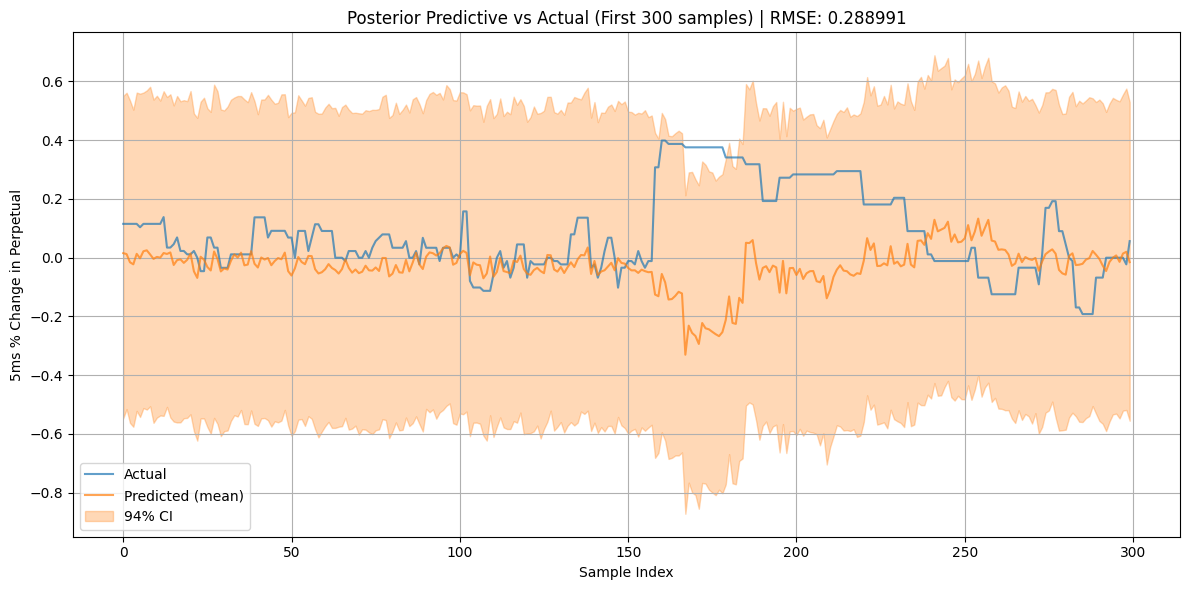

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_data[:300], label="Actual", alpha=0.7, color="C0")
plt.plot(y_pred_mean[:300], label="Predicted (mean)", alpha=0.7, color="C1")
plt.fill_between(
    range(300),
    np.percentile(y_pred_samples[:300], 3, axis=1),
    np.percentile(y_pred_samples[:300], 97, axis=1),
    color="C1",
    alpha=0.3,
    label="94% CI"
)
plt.title(f"Posterior Predictive vs Actual (First 300 samples) | RMSE: {rmse:.6f}")
plt.xlabel("Sample Index")
plt.ylabel("5ms % Change in Perpetual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Predicting Spot Based on Perpetual Market

In [13]:
features = [
    'perp_sudden_flag',
    'timedelta_ms_perp',
    'mid_price_perp',
    'trade_direction_perp'
]
target = 'window_5_pct_change'

# Drop rows with missing values
df_model = df[features + [target]].dropna().reset_index(drop=True)

# Scale features
scaler = StandardScaler()
X_data = scaler.fit_transform(df_model[features].values)
y_data = df_model[target].values

In [14]:
with pm.Model() as model_5ms_t:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_pred = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_5ms_t = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_5ms_t.extend(pm.sample_posterior_predictive(idata_5ms_t))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [y]


Output()

In [15]:
y_pred_samples = idata_5ms_t.posterior_predictive["y"].stack(sample=("chain", "draw")).values
y_pred_mean = y_pred_samples.mean(axis=1)

rmse = np.sqrt(mean_squared_error(y_data, y_pred_mean))
print(f"RMSE: {rmse:.6f}")

RMSE: 0.177149


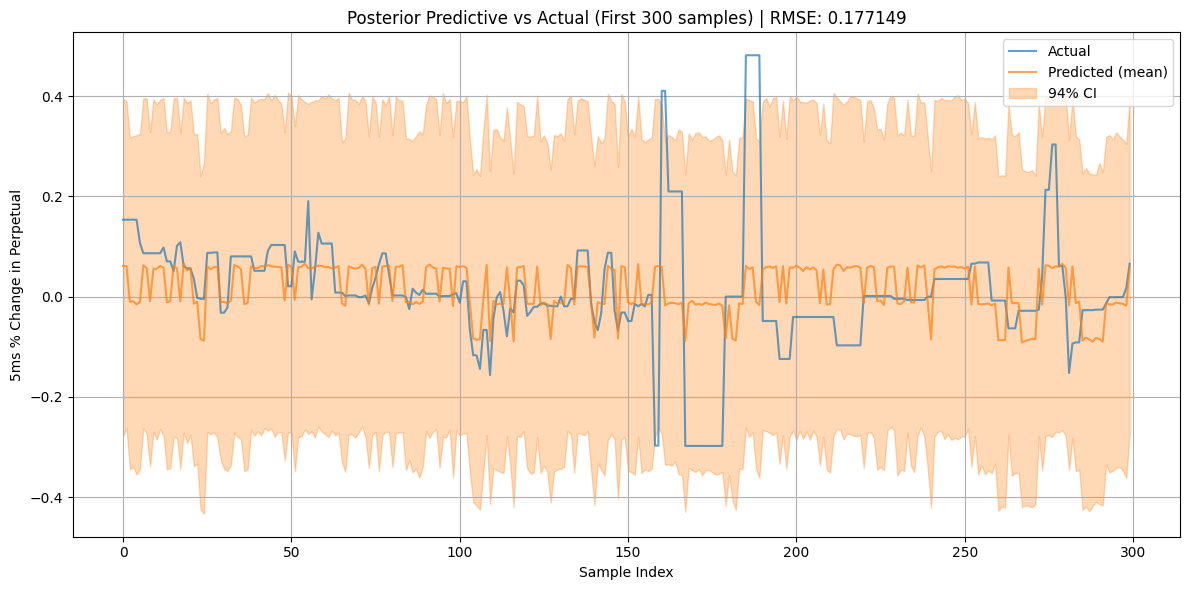

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_data[:300], label="Actual", alpha=0.7, color="C0")
plt.plot(y_pred_mean[:300], label="Predicted (mean)", alpha=0.7, color="C1")
plt.fill_between(
    range(300),
    np.percentile(y_pred_samples[:300], 3, axis=1),
    np.percentile(y_pred_samples[:300], 97, axis=1),
    color="C1",
    alpha=0.3,
    label="94% CI"
)
plt.title(f"Posterior Predictive vs Actual (First 300 samples) | RMSE: {rmse:.6f}")
plt.xlabel("Sample Index")
plt.ylabel("5ms % Change in Perpetual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# shift to detect reaction in next observation (i.e., within 1-row lag)
perp_reacts = df['perp_sudden_flag'].shift(-1).fillna(0).astype(int)
spot_reacts = df['spot_sudden_flag'].shift(-1).fillna(0).astype(int)

# detect leads
spot_leads = df['spot_sudden_flag'] & perp_reacts
perp_leads = df['perp_sudden_flag'] & spot_reacts

# prevent division by zero
sudden_spot = df['spot_sudden_flag'].sum()
sudden_perp = df['perp_sudden_flag'].sum()

spot_lead_pct = spot_leads.sum() / sudden_spot if sudden_spot > 0 else 0
perp_lead_pct = perp_leads.sum() / sudden_perp if sudden_perp > 0 else 0

print(f"Spot leads Perp in {spot_lead_pct:.2%} of sudden Spot changes.")
print(f"Perp leads Spot in {perp_lead_pct:.2%} of sudden Perp changes.")

Spot leads Perp in 38.25% of sudden Spot changes.
Perp leads Spot in 75.51% of sudden Perp changes.


Based on sudden price changes and their short-term effects (i.e., the next price update within a 5ms window), the perpetual market more frequently leads price discovery compared to the spot market.<br/>
Specifically:
- Approximately 75.51% of sudden changes in the perpetual market are followed by changes in the spot market.
- Only 38.25% of sudden spot changes are followed by perpetual market reactions.

In [18]:
# spot noise: sudden spot change not followed by perp
spot_noise = (
    (df['spot_sudden_flag'] == 1) &
    (df['perp_sudden_flag'].shift(-1).fillna(0) == 0)
)

# perpetual noise: sudden perp change not followed by spot
perp_noise = (
    (df['perp_sudden_flag'] == 1) &
    (df['spot_sudden_flag'].shift(-1).fillna(0) == 0)
)

# assign flags
df['spot_noise_flag'] = spot_noise.astype(int)
df['perp_noise_flag'] = perp_noise.astype(int)

spot_noise_pct = 100 * df['spot_noise_flag'].sum() / df['spot_sudden_flag'].sum()
perp_noise_pct = 100 * df['perp_noise_flag'].sum() / df['perp_sudden_flag'].sum()

print(f"Noise Rate (Spot): {spot_noise_pct:.2f}% of sudden spot moves do not affect perpetual")
print(f"Noise Rate (Perp): {perp_noise_pct:.2f}% of sudden perpetual moves do not affect spot")

Noise Rate (Spot): 61.75% of sudden spot moves do not affect perpetual
Noise Rate (Perp): 24.49% of sudden perpetual moves do not affect spot


Based on short-term reactions (within a 5ms window), we observe a significant amount of noise, sudden price changes in one market that do not influence the other market:
- 61.75%  of sudden spot market moves do not affect the perpetual market.
- 24.49% of sudden perpetual market moves do not affect the spot market.

These results indicate that:
- The spot market is more prone to isolated price movements that are likely noise.
- The perpetual market shows more consistent influence on the spot market, with fewer noisy signals.

In [19]:
spot_durations, spot_deltas = [], []
perp_durations, perp_deltas = [], []

spot_indices = df[df['spot_sudden_flag'] == 1].index
perp_indices = df[df['perp_sudden_flag'] == 1].index

for idx in spot_indices:
    dur, dlt = measure_momentum(df['time'], df['mid_price_spot'], idx)
    spot_durations.append(dur)
    spot_deltas.append(dlt)

for idx in perp_indices:
    dur, dlt = measure_momentum(df['time'], df['mid_price_perp'], idx)
    perp_durations.append(dur)
    perp_deltas.append(dlt)

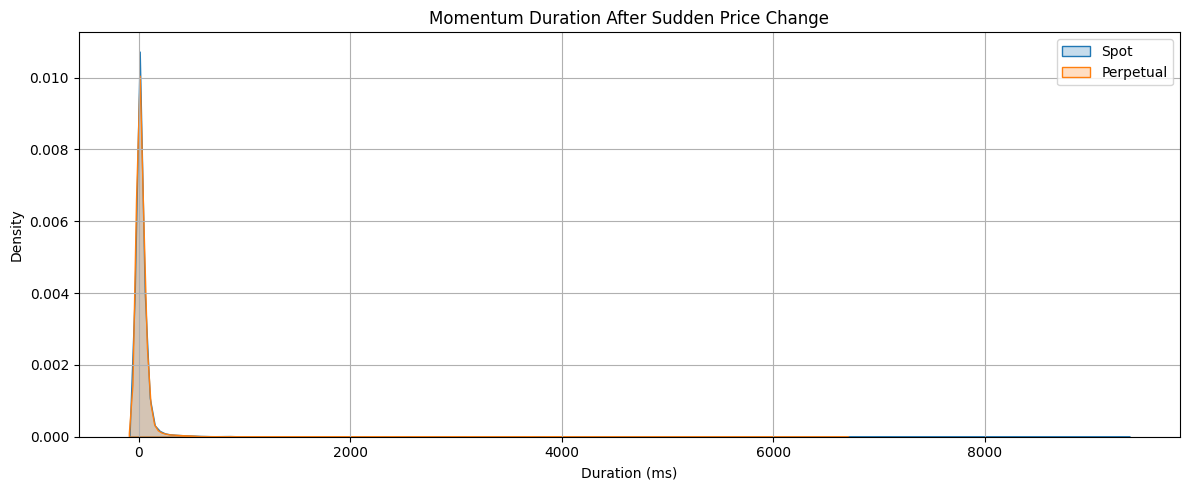

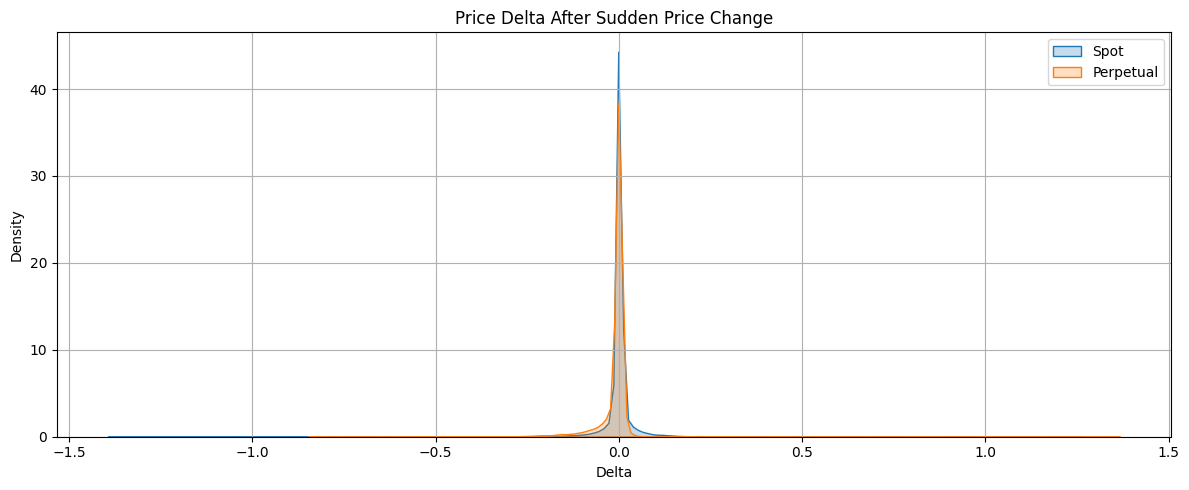

In [20]:
plt.figure(figsize=(12, 5))
sns.kdeplot(spot_durations, label='Spot', fill=True)
sns.kdeplot(perp_durations, label='Perpetual', fill=True)
plt.title("Momentum Duration After Sudden Price Change")
plt.xlabel("Duration (ms)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot price delta
plt.figure(figsize=(12, 5))
sns.kdeplot(spot_deltas, label='Spot', fill=True)
sns.kdeplot(perp_deltas, label='Perpetual', fill=True)
plt.title("Price Delta After Sudden Price Change")
plt.xlabel("Delta")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on momentum analysis after sudden price changes, the perpetual market tends to show slightly stronger and longer-lasting momentum than the spot market.
The majority of price reactions in both markets are short-lived and small in magnitude, with most momentum fading within milliseconds.